<a href="https://colab.research.google.com/github/DataSciWithJoshua/Shallow-Neural-Networks/blob/main/Homework1_JJ_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Common Setup

### Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import os
import time
from IPython.display import display, HTML


### Connecting to online drive or local file system for persistent storage

In [2]:
try:
    # if this fails, we are not running in a colab environment
    from google.colab import drive
    exec_env = "colab"
except ImportError:
    exec_env = "local"


match exec_env:
    case "colab":
        print("Running in Google Colab")
        drive.mount('/content/drive')
        drive_path = "/content/drive/My Drive/"
    case "local":
        print("Running locally")
        drive_path = "" # make sure this is a local valid drive path
    case _:
        print("Unknown execution environment")


Running locally


### Setup graphics processor if available

In [22]:
def device_setup(model):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Training on GPU.")
    
    elif torch.backends.mps.is_available():
        torch.backends.mps.benchmark = True
        device = torch.device("mps")
        print("MPS is available. Training with MPS.")
    
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Training on CPU.")

    model.to(device)

    return device

### Common Functions 

#### Define SNR Function

In [4]:
def calculate_snr(s: torch.Tensor, s_hat: torch.Tensor, epsilon: float = 1e-20) -> float:
    # Ensure both tensors are same shape
    assert s.shape == s_hat.shape, f"clean {s.shape} and predicted {s_hat.shape} must have the same shape."
    
    # Calculate numerator sum of squares of the clean signal
    signal_power = torch.sum(s.float() ** 2)
    
    # Calculate denominator: sum of squares of the noise (difference between clean and predicted)
    noise_power = torch.sum((s.float() - s_hat.float()) ** 2)
    
    # Avoid division by zero
    snr = 10 * torch.log10(signal_power / (noise_power + epsilon))
    
    return snr.item()


## Baseline Network Development and SVD-Based Compression

### Baseline

#### Setup

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
# import torch.nn.functional as F
import os
import time
from torch.nn import (
    Sigmoid, 
    ReLU, 
    Linear, 
    Sequential, 
    Module,
    init,
    BatchNorm1d,
)


#### Load Test and Training Data

In [25]:
mnist_train=torchvision.datasets.MNIST('mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]),
    )
mnist_test=torchvision.datasets.MNIST('mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ]),
    )

batch_size = 512

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_test,
    batch_size=batch_size,
    shuffle=False,
)


#### Network Definition

In [26]:
class NeuralNetwork(Module):
    def __init__(self, activation, init_method, normalize_batches):
        super(NeuralNetwork, self).__init__()

        if normalize_batches:
            self.layers = Sequential(
                Linear( 784, 1024), activation(), BatchNorm1d(1024), #  Input Layer / Layer 1
                Linear(1024, 1024), activation(), BatchNorm1d(1024), # Layer 2
                Linear(1024, 1024), activation(), BatchNorm1d(1024), # Layer 3
                Linear(1024, 1024), activation(), BatchNorm1d(1024), # Layer 4
                Linear(1024, 1024), activation(), BatchNorm1d(1024), # Layer 5
                Linear(1024, 10),                                    # Output Layer
            )
        else:
            self.layers = Sequential(
                Linear( 784, 1024), activation(), #  Input Layer / Layer 1
                Linear(1024, 1024), activation(), # Layer 2
                Linear(1024, 1024), activation(), # Layer 3
                Linear(1024, 1024), activation(), # Layer 4
                Linear(1024, 1024), activation(), # Layer 5
                Linear(1024, 10),                 # Output Layer
            )

        if init_method == "normal":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.normal_(layer.weight, mean=0, std=0.01)
        elif init_method == "xavier":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.xavier_uniform_(layer.weight)
        elif init_method == "kaiming":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.kaiming_uniform_(layer.weight, nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)
    

model_d = NeuralNetwork(   ReLU, init_method="xavier",  normalize_batches=False)
model_dict = {
    model_d: "model_d_batch_non_normalized",
}

In [27]:

# model_a = NeuralNetwork(Sigmoid, init_method="normal",  normalize_batches=False)
# model_b = NeuralNetwork(Sigmoid, init_method="xavier",  normalize_batches=False)
# model_c = NeuralNetwork(   ReLU, init_method="normal",  normalize_batches=False)
model_d = NeuralNetwork(   ReLU, init_method="xavier",  normalize_batches=False)
# model_e = NeuralNetwork(   ReLU, init_method="kaiming", normalize_batches=False)

# model_normlzd_a = NeuralNetwork(Sigmoid, init_method="normal",  normalize_batches=True)
# model_normlzd_b = NeuralNetwork(Sigmoid, init_method="xavier",  normalize_batches=True)
# model_normlzd_c = NeuralNetwork(   ReLU, init_method="normal",  normalize_batches=True)
# model_normlzd_d = NeuralNetwork(   ReLU, init_method="xavier",  normalize_batches=True)
# model_normlzd_e = NeuralNetwork(   ReLU, init_method="kaiming", normalize_batches=True)

model_dict = {
    # model_a: "model_a_batch_non_normalized",
    # model_b: "model_b_batch_non_normalized",
    # model_c: "model_c_batch_non_normalized",
    model_d: "model_d_batch_non_normalized",
    # model_e: "model_e_batch_non_normalized",

    # model_normlzd_a: "model_a_batch_normalized",
    # model_normlzd_b: "model_b_batch_normalized",
    # model_normlzd_c: "model_c_batch_normalized",
    # model_normlzd_d: "model_d_batch_normalized",
    # model_normlzd_e: "model_e_batch_normalized",
}

#### Network Training

In [28]:
def train_and_test_network(model,train_loader,test_loader,num_epochs,input_size,device,loss_func,optimizer_func,checkpoint_list=[]):
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        correct_pred_train = 0
        total_pred_train = 0
        correct_pred_test = 0
        total_pred_test = 0
        running_loss = 0.0
        
        # Train the model
        train_start_time = time.time()
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Reshape images to (batch_size, input_size)
            images = images.reshape(-1, input_size)
            labels = labels.long()

            # Move to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs_train = model(images)
            loss = loss_func(outputs_train, labels) # Applies softmax
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer_func.zero_grad() # clear the gradients at beginning of each backward pass
            loss.backward()
            optimizer_func.step() # update the weights

            # Calculate accuracy
            _, predicted_train = torch.max(outputs_train.data, 1)
            total_pred_train += labels.size(0)
            correct_pred_train += (predicted_train == labels).sum().item()

        # Manually save off weights at 20th epoch
        if (epoch+1) in checkpoint_list:
            # Save model, accuracy, and loss per epoch
            assignment_part = "1_weights"
            model_description = "softmax_regression"
            full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{epoch+1}'
            print(full_path)

            np.save(f'{full_path}-train_acc.npy',  np.array(train_acc))
            np.save(f'{full_path}-test_acc.npy',   np.array(test_acc))
            np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
            torch.save(model.state_dict(), f'{full_path}.pt')
            print(f'Model saved at {epoch+1=}')

        
        train_time = time.time() - train_start_time
        
        # Test the model
        test_start_time = time.time()
        model.eval()
        with torch.no_grad(): # no gradient updates
            for images, labels in test_loader:
                images = images.reshape(-1, input_size)
                labels = labels.long()

                # Move to device
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs_test = model(images)

                # Calculate accuracy
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_pred_test += labels.size(0)
                correct_pred_test += (predicted_test == labels).sum().item()

        test_time  = time.time() - test_start_time
        
        # Log loss and accuracy
        epoch_loss = running_loss / batch_size
        train_loss.append(epoch_loss)

        train_accuracy = 100 * correct_pred_train / total_pred_train
        train_acc.append(train_accuracy)
        test_accuracy  = 100 * correct_pred_test  / total_pred_test
        test_acc.append(test_accuracy)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {epoch_loss:.4f}, \
        Train Acc: {train_accuracy:.2f}% \
        Test  Acc: { test_accuracy:.2f}% \
        Train Time: {train_time:.2f} \
        Test  Time: {test_time:.2f} \
        Epoch Time: {epoch_time:.2f}')

    print(f'Total Time: {(time.time()-start_time):.2f}')

    return train_acc, test_acc, train_loss, model

#### Run the baseline model

In [29]:
# Hyperparameter Setup
input_size = 784 # 28*28 pixel images flattened to 1d vector
num_classes = 10 # digits 0-9
num_epochs = 200
learning_rate = 0.05

# Run Batch of Networks
for network,desc in model_dict.items():
    
    # Select Network
    model = network

    # Choose loss func and optimizer
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer_func = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Setup cuda if available
    device = device_setup(model)

    print(f'Running {model} - {desc}')

    # Train and Test
    train_acc, test_acc, train_loss, model = \
        train_and_test_network(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader,
            num_epochs=num_epochs,
            input_size=input_size,
            device=device,
            loss_func=loss_func,
            optimizer_func=optimizer_func,
        )

    # Save model, accuracy, and loss per epoch
    assignment_part = "1_weights"
    model_description = desc
    full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{num_epochs}'
    print(full_path)

    np.save(f'{full_path}-train_acc.npy', np.array(train_acc))
    np.save(f'{full_path}-test_acc.npy', np.array(test_acc))
    np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
    torch.save(model.state_dict(), f'{full_path}.pt')
    print(f'{model} - {desc} data saved to disk')

MPS is available. Training with MPS.
Running NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
) - model_d_batch_non_normalized
Epoch [1/200],         Train Loss: 0.1511,         Train Acc: 81.33%         Test  Acc: 91.09%         Train Time: 6.81         Test  Time: 0.80         Epoch Time: 7.61
Epoch [2/200],         Train Loss: 0.0526,         Train Acc: 93.11%         Test  Acc: 94.11%         Train Time: 5.72         Test  Time: 0.71         Epoch Time: 6.44
Epoch [3/200],         Train Loss: 0.0382,         Train Acc: 95.04%         

#### Plot Baseline Train vs Validation


Final Test Accuracy: 98.14%


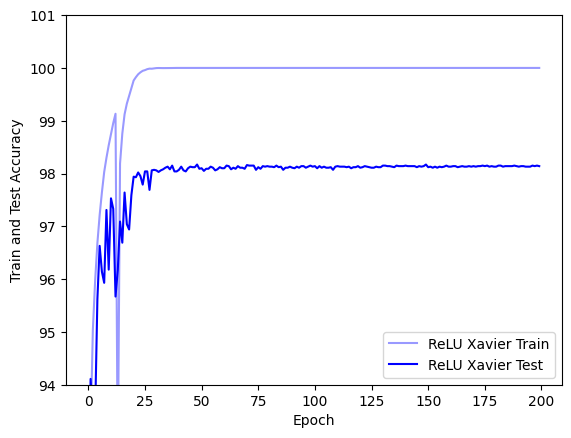

In [35]:
# Load Data
assignment_part = "1_weights"
model_description = "model_relu_xavier_baseline"
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}'
train_acc_xavier = np.load(f'{full_path}-train_acc.npy')
test_acc_xavier = np.load(f'{full_path}-test_acc.npy')

plt.plot(train_acc_xavier,  color='blue', alpha=0.4,  label='ReLU Xavier Train')
plt.plot(test_acc_xavier,   color='blue',             label='ReLU Xavier Test')

print(f'Final Test Accuracy: {test_acc_xavier[-1]}%')
plt.xlabel('Epoch')
plt.ylabel('Train and Test Accuracy')
plt.ylim(94,101)
plt.legend()
plt.show()

### SVD 

#### Load Baseline Model

In [36]:
import copy

# Load stored weights
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}.pt'
state_dict = torch.load(full_path, weights_only=False)
baseline_state_dict = copy.deepcopy(state_dict)


#### Define Network Evaluation Function

In [37]:
def evaluate_network(_compressed_model, test_loader, input_size, device):
    correct_pred_test = 0
    total_pred_test = 0

    _compressed_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            
            # Reshape and move data to device
            images = images.reshape(-1, input_size).to(device)
            labels = labels.long().to(device)

            # Forward pass
            outputs_test = _compressed_model(images)

            # Get predictions and update counts
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_pred_test += labels.size(0)
            correct_pred_test += (predicted_test == labels).sum().item()

    # Calculate accuracy
    test_accuracy = 100 * correct_pred_test / total_pred_test

    return test_accuracy

#### Define helper functions to compress data and get svd

In [38]:
def compress_model(compressed_model, svd_weights, D, input_size) -> NeuralNetwork:
    # Update only weight params, skip last layer
    for layer, (name, param) in enumerate(compressed_model.named_parameters()):
        if name in svd_weights:
            U, S, V = svd_weights[name]

            # For D_full, adjust D for the layer size
            if layer > 0 and D==input_size:
                D = 1024

            # Compress
            U_comp = U[:, :D]
            S_comp = torch.diag(S[:D])
            V_comp = V.T[:, :D]

            # Reconstruct compressed weight matrix
            W_hat = U_comp @ S_comp @ V_comp.T
            # if D==20: print(W_hat[0][0:9])
            if D==20: print(W_hat.shape)
            assert param.shape == W_hat.shape, f"Reconstructed matrix does not match expected size, W_hat: {W_hat.shape} vs param:{param.shape}"
            param.data = W_hat            
            
    return compressed_model


def get_svd_weights(model, classes=10) -> dict:
    """Returns dictionary of each SVD weight matrix in a model
    
        Skips last layer
    """
    weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name and param.data.shape[0] > classes:
            U, S, V = torch.linalg.svd(param.data, full_matrices=False)
            weights.update({name:(U,S,V)})
    return weights



def cnt_parameters(layer_sizes, D=None, input_size=784, include_bias=True):
    params = 0
    layer_input_size = input_size

    for output_size in layer_sizes:
        # Perform baseline cnt
        if D is None or D==input_size:
            params += layer_input_size * output_size
        # Perform SVD cnt
        else:
            # Calculate parameters for each layer
            U_params = layer_input_size * D
            S_params = D
            V_params = D * output_size
            params += U_params + S_params + V_params

        if include_bias:
            params += output_size
            
        # Update current input size to the output size of this layer
        layer_input_size = output_size
    return params


#### Score each compressed model

In [39]:
D_values = [10, 20, 50, 100, 200, 784]
results_acc = {}

# Get SVD weights once and reuse
svd_weights = get_svd_weights(model)

# Evaluate Compressed Weights
for d in D_values:
    # Reload model incase inadvertent changes were made
    model.load_state_dict(baseline_state_dict)

    # Update Model with compressed weights
    compressed_model = compress_model(model, svd_weights, d, input_size).to(device)
    
    # Evaluate Model Test Accuracy
    test_accuracy = evaluate_network(compressed_model, test_loader, input_size=784, device=device)
    
    # Log Accuracy
    if d < input_size:
        print(f"Accuracy for    D={d:3d}: {test_accuracy:2.2f}%")
        results_acc[d] = test_accuracy
    else:
        print(f"Accuracy for   D=full: {test_accuracy:2.2f}%")
        results_acc["D_full"] = test_accuracy


# Evaluate Baseline Weights

# Reload model incase inadvertent changes were made
model.load_state_dict(baseline_state_dict)

# Evaluate Model Test Accuracy
test_accuracy = evaluate_network(model, test_loader, input_size=784, device=device)
print(f"Accuracy for Baseline: {test_accuracy:2.2f}%")
results_acc["baseline"] = test_accuracy



/var/folders/cj/yhf6q8bn0nqfvv1_wrdfq7gw0000gn/T/ipykernel_97163/4150578353.py:34: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  U, S, V = torch.linalg.svd(param.data, full_matrices=False)


Accuracy for    D= 10: 22.89%
torch.Size([1024, 784])
torch.Size([1024, 1024])
torch.Size([1024, 1024])
torch.Size([1024, 1024])
torch.Size([1024, 1024])
Accuracy for    D= 20: 27.14%
Accuracy for    D= 50: 35.61%
Accuracy for    D=100: 67.39%
Accuracy for    D=200: 87.70%
Accuracy for   D=full: 98.14%
Accuracy for Baseline: 98.14%


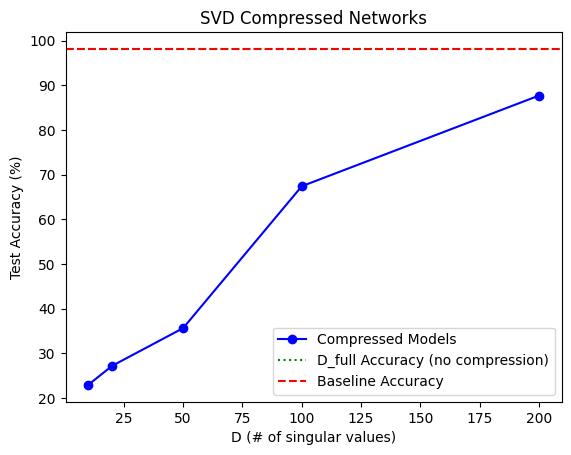

D: 10 - Test Accuracy: 22.89% - Parameters: 137,044
D: 20 - Test Accuracy: 27.14% - Parameters: 267,934
D: 50 - Test Accuracy: 35.61% - Parameters: 660,604
D:100 - Test Accuracy: 67.39% - Parameters: 1,315,054
D:200 - Test Accuracy: 87.70% - Parameters: 2,623,954
D_full - Test Accuracy: 98.14% - Parameters: 6,062,090
baseline - Test Accuracy: 98.14% - Parameters: 6,062,090


In [40]:
D_values = [10, 20, 50, 100, 200, 784]

def plot_svd_compression_results(results):

    # Split values
    D_values, accuracies = zip(*results.items())

    # Plot
    plt.plot(D_values[:-2], accuracies[:-2], marker='o', linestyle='-', color='b', label='Compressed Models')
    plt.axhline(y=results['D_full'],   color='g', linestyle=':', label='D_full Accuracy (no compression)')
    plt.axhline(y=results['baseline'], color='r', linestyle='--', label='Baseline Accuracy')
    
    plt.xlabel('D (# of singular values)')
    plt.ylabel('Test Accuracy (%)')
    plt.title('SVD Compressed Networks')
    plt.legend()
    plt.show()


plot_svd_compression_results(results_acc)

layer_sizes = [1024, 1024, 1024, 1024, 1024, 1024, 10]
for Dval,acc in results_acc.items():
    # print(Dval)
    if isinstance(Dval,int):
        cnt = cnt_parameters(layer_sizes=layer_sizes, D=Dval, input_size=784, include_bias=True)
        print(f'D:{Dval:3d} - Test Accuracy: {acc:.2f}% - Parameters: {cnt:,}')
    else:
        cnt = cnt_parameters(layer_sizes=layer_sizes, D=None, input_size=784, include_bias=True)
        print(f'{Dval} - Test Accuracy: {acc:.2f}% - Parameters: {cnt:,}')


## Low-Rank Approximation and Fine-Tuning for Performance Recovery

### Setup

In [41]:
import copy
import torch.nn as nn

### Load Baseline Model

In [42]:
# Load stored weights
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}.pt'
state_dict = torch.load(full_path, weights_only=False)
baseline_state_dict = copy.deepcopy(state_dict)

model = NeuralNetwork(   ReLU, init_method="xavier",  normalize_batches=False)
model.load_state_dict(baseline_state_dict)
svd_weights = get_svd_weights(model)
print(svd_weights.keys())

dict_keys(['layers.0.weight', 'layers.2.weight', 'layers.4.weight', 'layers.6.weight', 'layers.8.weight'])


### Define Compressed Network

#### Eval Network Only

In [43]:
def evaluate_network(_compressed_model, test_loader, input_size, device):
    correct_pred_test = 0
    total_pred_test = 0

    _compressed_model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            
            # Reshape and move data to device
            images = images.reshape(-1, input_size).to(device)
            labels = labels.long().to(device)

            # Forward pass
            outputs_test = _compressed_model(images)

            # Get predictions and update counts
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_pred_test += labels.size(0)
            correct_pred_test += (predicted_test == labels).sum().item()

    # Calculate accuracy
    test_accuracy = 100 * correct_pred_test / total_pred_test

    return test_accuracy

#### Define Network Arch

In [74]:
class SVDCompressedNetwork(nn.Module):
    def __init__(self, svd_weights, layer_sizes, activation):
        super(SVDCompressedNetwork, self).__init__()
        # self.layers = nn.ModuleList()
        self.biases = nn.ParameterList()
        self.activations = nn.ModuleList()

        # Create factorized layers with U and V for each layer
        for idx, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            # print(idx, in_size, out_size)

            if out_size == 1024:
                # Get previous svd results
                U_full, S_full, V_full = svd_weights[f'layers.{idx*2}.weight']
                D = 20              
                U = nn.Parameter(U_full[:, :D])
                V = nn.Parameter(torch.diag(S_full[:D]) @ V_full.T[:, :D].T)

                self.register_parameter(f'U_{idx}', U)
                self.register_parameter(f'V_{idx}', V)

                # Bias parameter for each layer
                bias = nn.Parameter(torch.zeros(out_size))
                self.biases.append(bias)

                # Activation for each layer
                self.activations.append(activation())
            else:
                final_layer = nn.Linear(in_size, out_size)
                self.register_parameter("final_weight", final_layer.weight)
                self.register_parameter("final_bias", final_layer.bias)

    def forward(self, x):
        for idx in range(len(self.biases)+1):
            if idx < len(self.activations):  
                U = getattr(self, f'U_{idx}')
                V = getattr(self, f'V_{idx}')
                W_hat = U @ V
                x = self.activations[idx](x @ W_hat.T + self.biases[idx])

            # Final layer
            else:
                # print(f'Final Layer X input{x.shape=}')
                x = x @ self.final_weight.T + self.final_bias
                # print(f'Final Layer X output{x.shape=}')

        return x

layer_sizes = [784, 1024, 1024, 1024, 1024, 1024, 10]   
svd_20_model = SVDCompressedNetwork(svd_weights, layer_sizes=layer_sizes, activation=nn.ReLU).to(device)

test_accuracy_20 = evaluate_network(svd_20_model, test_loader, input_size=784, device=device)
print(f"Accuracy for D={20}: {test_accuracy_20:2.2f}%")

svd_model_dict = {
    svd_20_model: "svd_model_20",
}

Accuracy for D=20: 9.52%


### Network Training

In [45]:
def train_and_test_svd_network(model,train_loader,test_loader,num_epochs,input_size,device,loss_func,optimizer_func):
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        correct_pred_train = 0
        total_pred_train = 0
        correct_pred_test = 0
        total_pred_test = 0
        running_loss = 0.0
        
        # Train the model
        train_start_time = time.time()
        model.train()
        for images, labels in train_loader:
            # Reshape images to (batch_size, input_size)
            images = images.reshape(-1, input_size).to(device)
            labels = labels.long().to(device)

            # Forward pass
            outputs_train = model(images)
            loss = loss_func(outputs_train, labels) # Applies softmax
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer_func.zero_grad() # clear the gradients at beginning of each backward pass
            loss.backward()
            optimizer_func.step() # update the weights

            # Calculate accuracy
            _, predicted_train = torch.max(outputs_train.data, 1)
            total_pred_train += labels.size(0)
            correct_pred_train += (predicted_train == labels).sum().item()
        
        train_time = time.time() - train_start_time
        
        # Test the model
        test_start_time = time.time()
        model.eval()
        with torch.no_grad(): # no gradient updates
            for images, labels in test_loader:
                # Reshape and move data to device
                images = images.reshape(-1, input_size).to(device)
                labels = labels.long().to(device)

                # Forward pass
                outputs_test = model(images)

                # Calculate accuracy
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_pred_test += labels.size(0)
                correct_pred_test += (predicted_test == labels).sum().item()

        test_time  = time.time() - test_start_time
        
        # Log loss and accuracy
        epoch_loss = running_loss / batch_size
        train_loss.append(epoch_loss)

        train_accuracy = 100 * correct_pred_train / total_pred_train
        train_acc.append(train_accuracy)
        test_accuracy  = 100 * correct_pred_test  / total_pred_test
        test_acc.append(test_accuracy)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {epoch_loss:.4f}, \
        Train Acc: {train_accuracy:.2f}% \
        Test  Acc: { test_accuracy:.2f}% \
        Train Time: {train_time:.2f} \
        Test  Time: {test_time:.2f} \
        Epoch Time: {epoch_time:.2f}')

    print(f'Total Time: {(time.time()-start_time):.2f}')

    return train_acc, test_acc, train_loss, model

### Run Network

In [ ]:
# Hyperparameter Setup
input_size = 784 # 28*28 pixel images flattened to 1d vector
num_classes = 10 # digits 0-9
num_epochs = 200
learning_rate = 0.005

# Run Batch of Networks
for network,desc in svd_model_dict.items():
    
    # Select Network
    model = network

    # Choose loss func and optimizer
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer_func = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Setup cuda if available
    device = device_setup(model)

    # Check Path
    assignment_part = "2_weights"
    model_description = desc
    full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{num_epochs}'
    print(full_path)

    print(f'Running {model} - {desc}')

    # Train and Test
    train_acc, test_acc, train_loss, model = \
        train_and_test_svd_network(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader,
            num_epochs=num_epochs,
            input_size=input_size,
            device=device,
            loss_func=loss_func,
            optimizer_func=optimizer_func,
        )
    
    # Save model, accuracy, and loss per epoch
    np.save(f'{full_path}-train_acc.npy', np.array(train_acc))
    np.save(f'{full_path}-test_acc.npy', np.array(test_acc))
    np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
    torch.save(model.state_dict(), f'{full_path}.pt')
    print(f'{model} - {desc} data saved to disk')

### Plot Results

SVD D=20 Orig Test Accuracy: 27.14%
SVD D=20 New  Test Accuracy: 97.10%


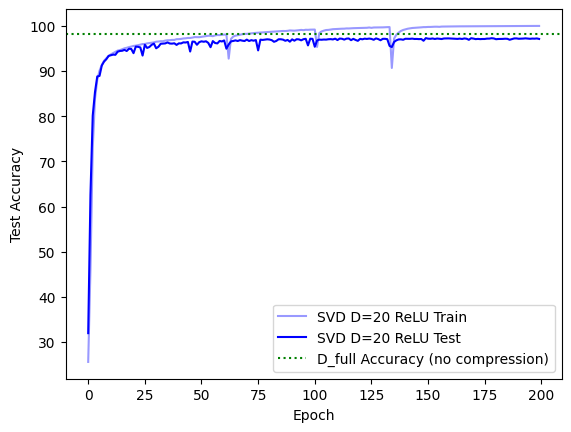

In [57]:
# Load Data
assignment_part = "2_weights"
model_description = "svd_model_20"
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{200}'
train_acc_svd20 = np.load(f'{full_path}-train_acc.npy')
test_acc_svd20 = np.load(f'{full_path}-test_acc.npy')

plt.plot(train_acc_svd20,  color='blue', alpha=0.4,  label='SVD D=20 ReLU Train')
plt.plot(test_acc_svd20,   color='blue',             label='SVD D=20 ReLU Test')
plt.axhline(y=98.14,   color='g', linestyle=':', label='D_full Accuracy (no compression)')


print(f'SVD D=20 Orig Test Accuracy: {results_acc[20]:.2f}%')
print(f'SVD D=20 New  Test Accuracy: {test_acc_svd20[-1]:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
# plt.ylim(20,101)
plt.legend()
plt.show()

## SVD-Aware Training for Compressed Networks

### Setup

In [58]:
import copy

### Load Baseline Model

In [59]:
# Load stored weights
full_path = f'{os.getcwd()}/1_weights/model_relu_xavier_baseline.pt'
state_dict = torch.load(full_path, weights_only=False)
baseline_state_dict = copy.deepcopy(state_dict)
baseline_model = NeuralNetwork(   ReLU, init_method="xavier",  normalize_batches=False)
baseline_model.load_state_dict(baseline_state_dict)

<All keys matched successfully>

### Define Runtime SVD func

In [61]:
def svd_compress(_model, D=20):
    # Update only weight params, skip last layer    
    with torch.no_grad():
        for name, param in _model.named_parameters():
            if 'weight' in name:
                U, S, V = torch.linalg.svd(param.data, full_matrices=False)
                U_comp = U[:, :D]
                S_comp = torch.diag(S[:D])
                V_comp = V.T[:, :D]
                param.data = U_comp @ S_comp @ V_comp.T            
            
    return _model

### Network Training

In [62]:
def train_and_test_network_svd_at_runtime(model,train_loader,test_loader,num_epochs,input_size,device,loss_func,optimizer_func):
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        correct_pred_train = 0
        total_pred_train = 0
        correct_pred_test = 0
        total_pred_test = 0
        running_loss = 0.0
        
        # Train the model
        train_start_time = time.time()
        svd_compressed_model = svd_compress(model, D=20)
        svd_compressed_model.train()
        for images, labels in train_loader:
            # Reshape images to (batch_size, |input_size)
            images = images.reshape(-1, input_size).to(device)
            labels = labels.long().to(device)

            # Forward pass
            outputs_train = svd_compressed_model(images)
            loss = loss_func(outputs_train, labels) # Applies softmax
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer_func.zero_grad() # clear the gradients at beginning of each backward pass
            loss.backward()
            optimizer_func.step() # update the weights

            # Calculate accuracy
            _, predicted_train = torch.max(outputs_train.data, 1)
            total_pred_train += labels.size(0)
            correct_pred_train += (predicted_train == labels).sum().item()
        
        train_time = time.time() - train_start_time
        
        # Test the model
        test_start_time = time.time()
        model.eval()
        with torch.no_grad(): # no gradient updates
            for images, labels in test_loader:
                # Reshape and move data to device
                images = images.reshape(-1, input_size).to(device)
                labels = labels.long().to(device)

                # Forward pass
                outputs_test = model(images)

                # Calculate accuracy
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_pred_test += labels.size(0)
                correct_pred_test += (predicted_test == labels).sum().item()

        test_time  = time.time() - test_start_time
        
        # Log loss and accuracy
        epoch_loss = running_loss / batch_size
        train_loss.append(epoch_loss)

        train_accuracy = 100 * correct_pred_train / total_pred_train
        train_acc.append(train_accuracy)
        test_accuracy  = 100 * correct_pred_test  / total_pred_test
        test_acc.append(test_accuracy)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {epoch_loss:.4f}, \
        Train Acc: {train_accuracy:.2f}% \
        Test  Acc: { test_accuracy:.2f}% \
        Train Time: {train_time:.2f} \
        Test  Time: {test_time:.2f} \
        Epoch Time: {epoch_time:.2f}')

    print(f'Total Time: {(time.time()-start_time):.2f}')

    return train_acc, test_acc, train_loss, model

### Run Network

In [ ]:
# Hyperparameter Setup
input_size = 784 # 28*28 pixel images flattened to 1d vector
num_classes = 10 # digits 0-9
num_epochs = 200
learning_rate = 0.005

# Select Network
model = baseline_model

# Choose loss func and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer_func = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Setup cuda if available
device = device_setup(model)

# Check Path
assignment_part = "3_weights"
model_description = "svd_d20_at_runtime"
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{num_epochs}'
print(full_path)

print(f'Running {model} - {desc}')

# Train and Test
train_acc, test_acc, train_loss, model = \
    train_and_test_network_svd_at_runtime(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        num_epochs=num_epochs,
        input_size=input_size,
        device=device,
        loss_func=loss_func,
        optimizer_func=optimizer_func,
    )

# Save model, accuracy, and loss per epoch
np.save(f'{full_path}-train_acc.npy', np.array(train_acc))
np.save(f'{full_path}-test_acc.npy', np.array(test_acc))
np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
torch.save(model.state_dict(), f'{full_path}.pt')
print(f'{model} - {desc} data saved to disk')

### Plot Results

SVD D=20 Original   Test Accuracy: 27.14%
SVD D=20 FineTuned  Test Accuracy: 97.10%
SVD D=20 Each Epoch Test Accuracy: 97.27%
SVD Each Epoch D=20 Test Accuracy


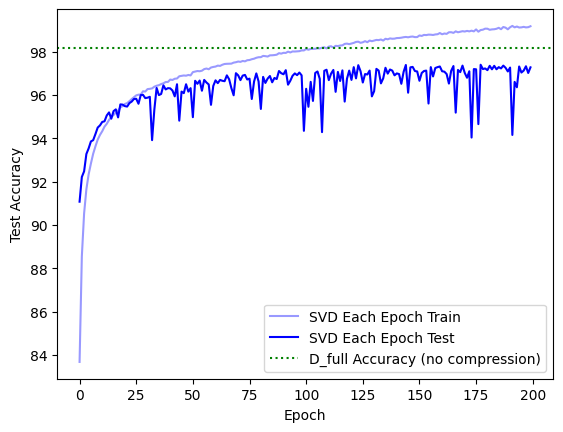

In [69]:
# Load Data
assignment_part = "3_weights"
model_description = "svd_d20_at_runtime"
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{200}'
train_acc_svd_ee_d20 = np.load(f'{full_path}-train_acc.npy')
test_acc_svd_ee_d20 = np.load(f'{full_path}-test_acc.npy')

plt.plot(train_acc_svd_ee_d20,  color='blue', alpha=0.4,  label='SVD Each Epoch Train')
plt.plot(test_acc_svd_ee_d20,   color='blue',             label='SVD Each Epoch Test')
plt.axhline(y=results_acc['baseline'],   color='g', linestyle=':', label='D_full Accuracy (no compression)')


print(f'SVD D=20 Original   Test Accuracy: {results_acc[20]:.2f}%')
print(f'SVD D=20 FineTuned  Test Accuracy: {test_acc_svd20[-1]:.2f}%')
print(f'SVD D=20 Each Epoch Test Accuracy: {test_acc_svd_ee_d20[-1]:.2f}%')

print(f'SVD Each Epoch D=20 Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
# plt.ylim(20,105)
plt.legend()
plt.show()

## Building a Siamese Network for Speaker Verification

### Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import time
import pickle    
import itertools   
import random

In [7]:
def calculate_snr(s: torch.Tensor, s_hat: torch.Tensor, epsilon: float = 1e-20) -> float:
    # Ensure both tensors are same shape
    assert s.shape == s_hat.shape, f"clean {s.shape} and predicted {s_hat.shape} must have the same shape."
    
    # Calculate numerator sum of squares of the clean signal
    signal_power = torch.sum(s ** 2)
    
    # Calculate denominator: sum of squares of the noise (difference between clean and predicted)
    noise_power = torch.sum((s - s_hat) ** 2)
    
    # Avoid division by zero
    snr = 10 * torch.log10(signal_power / (noise_power + epsilon))
    
    return snr.item()

### Read Data

In [2]:
def get_pickled_train_and_test_data():
    train_file = "trs.pkl"
    test_file  = "tes.pkl"
    with open(train_file, 'rb') as f:
        train_data = pickle.load(f)
        
    with open(test_file, 'rb') as f:
        test_data = pickle.load(f)
    
    return train_data, test_data


train, test = get_pickled_train_and_test_data()
train.shape,test.shape

train_stft = librosa.stft(train, n_fft=1024, hop_length=512)
test_stft  = librosa.stft(test , n_fft=1024, hop_length=512)
train_stft.shape,test_stft.shape



((500, 513, 32), (200, 513, 45))

### Setup Batches

In [3]:
def generate_pairs(data, L=45):
    num_speakers = data.shape[0] // 10
    positive_pairs = []
    negative_pairs = []

    for id in range(num_speakers):
        # Get this speakers list of utterances
        start_idx = id * 10
        speaker_utterances = data[start_idx:start_idx + 10]

        # Generate all possible pairs for this speaker, i.e 45
        all_positive_pairs = list(itertools.combinations(speaker_utterances, 2))

        if L > len(all_positive_pairs):
            raise ValueError("L cannot exceed # of possible positive pairs (45).")
        
        positive_pairs += random.sample(all_positive_pairs, L)

        # Generate negative pairs (different speaker pairs)
        other_speakers_data = np.concatenate([data[:start_idx], data[start_idx + 10:]])
        # print(start_idx, data[:start_idx].shape, data[start_idx + 10:].shape, other_speakers_data.shape)
        # other_speaker_samples = other_speakers_data[random.choices(range(len(other_speakers_data)), k=L)]
        other_speaker_samples = [other_speakers_data[i] for i in random.choices(range(len(other_speakers_data)), k=L)]
        # print(other_speaker_samples.shape)
        first_speaker_samples = random.choices(speaker_utterances, k=L)
        # print(first_speaker_samples[0].shape)

        negative_pairs += [(first_speaker_samples[i], other_speaker_samples[i]) for i in range(L)]
        # print(negative_pairs[1][0].shape, len(negative_pairs))
    
    return positive_pairs, negative_pairs

L=45
train_pos, train_neg = generate_pairs(train_stft, L=L)
print(len(train_pos)//L, train_pos[0][0].shape)
print(len(train_neg)//L, train_neg[0][0].shape)

test_pos,  test_neg  = generate_pairs(test_stft, L=L)
print(len(test_pos)//L, test_pos[0][0].shape)
print(len(test_neg)//L, test_neg[0][0].shape)

50 (513, 32)
50 (513, 32)
20 (513, 45)
20 (513, 45)


### Setup Dataloader

In [4]:
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for Siamese Network
class SpeakerVerificationDataset(Dataset):
    def __init__(self, positive_pairs, negative_pairs):
        self.data = positive_pairs + negative_pairs
        self.labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        pair = self.data[idx]
        label = self.labels[idx]
        # Convert pair to tensors and add channel dimension
        utterance1 = torch.tensor(pair[0], dtype=torch.float32).unsqueeze(0)  # Shape (1, 513, T)
        utterance2 = torch.tensor(pair[1], dtype=torch.float32).unsqueeze(0)  # Shape (1, 513, T)
        label = torch.tensor(label, dtype=torch.float32)
        return utterance1, utterance2, label

# Create dataset and dataloaders
train_dataset = SpeakerVerificationDataset(train_pos, train_neg)
test_dataset = SpeakerVerificationDataset(test_pos, test_neg)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define Network

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpectrogramEncoder(nn.Module):
    def __init__(self):
        super(SpectrogramEncoder, self).__init__()
        # Define convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # # Define a fully connected layer to produce a fixed-length embedding
        # self.fc = nn.Linear(128 * 64 * 4, 256)  # Adjust dimensions as per your spectrogram size

        # GRU layer for temporal dependencies
        self.gru = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
    
    def forward(self, x):
        # Apply convolutional layers with activation and pooling
        # print(f'Start {x.shape=}')
        x = F.relu(self.conv1(x))
        # print(f'conv1 {x.shape=}')
        x = F.max_pool2d(x, (4, 2))
        # print(f'pool1 {x.shape=}')
        x = F.relu(self.conv2(x))
        # print(f'conv2 {x.shape=}')
        x = F.max_pool2d(x, (4, 4))
        # print(f'pool2 {x.shape=}')
        
        # Reshape for GRU input
        x = x.permute(0, 3, 2, 1).contiguous()  # Shape (batch_size, 4, 128, 64)
        # print(f'perm1 {x.shape=}')
        # x = x.view(x.size(0), x.size(1), -1)     # Shape (batch_size, H, 128*W)
        x = F.adaptive_avg_pool2d(x, (1, 128))  # Shape: (256, 4, 1, 128)
        x = x.squeeze(2)
        # print(f'view 1{x.shape=}')
        
        # GRU layer
        _, hidden = self.gru(x)
        # print(f'hidden{hidden.shape=}')
        return hidden[-1]

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.encoder = SpectrogramEncoder()
        
    def forward(self, input1, input2):
        # Use the SpectrogramEncoder for both branches of the Siamese network
        embedding1 = self.encoder(input1)
        embedding2 = self.encoder(input2)
        
        # Get logistic regression output using sigmoid applied to inner product
        inner_product = torch.sum(embedding1 * embedding2, dim=1)
        similarity = torch.sigmoid(inner_product)
        
        return similarity

# Loss function and training utility
def siamese_loss(predictions, labels):
    return F.binary_cross_entropy_with_logits(predictions, labels)

### Network Training

In [119]:
def train_and_test_network_speaker_ver(model,train_loader,test_loader,num_epochs,input_size,device,loss_func,optimizer_func):
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        correct_pred_train = 0
        total_pred_train = 0
        correct_pred_test = 0
        total_pred_test = 0
        running_loss = 0.0
        
        # Train the model
        train_start_time = time.time()
        model.train()

        for batch_idx, (input1, input2, labels) in enumerate(train_loader):
            # move data to device
            input1 = input1.to(device)
            input2 = input2.to(device)
            labels = labels.to(device)

            # Forward pass
            similarity_scores = model(input1, input2)

            loss = loss_func(similarity_scores, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer_func.zero_grad() # clear the gradients at beginning of each backward pass
            loss.backward()
            optimizer_func.step() # update the weights

            # Calculate accuracy
            predicted_train = (similarity_scores >= 0.5).float()
            correct_pred_train += (predicted_train == labels).sum().item()
            total_pred_train += labels.size(0)
        
        train_time = time.time() - train_start_time
        
        # Test the model
        test_start_time = time.time()
        model.eval()
        with torch.no_grad(): # no gradient updates
            for batch_idx, (input1, input2, labels) in enumerate(test_loader):
                # move data to device
                input1 = input1.to(device)
                input2 = input2.to(device)
                labels = labels.to(device)

                # Forward pass
                similarity_scores = model(input1, input2)

                # Calculate accuracy
                predicted_test = (similarity_scores >= 0.5).float()
                correct_pred_test += (predicted_test == labels).sum().item()
                total_pred_test += labels.size(0)

        test_time  = time.time() - test_start_time
        
        # Log loss and accuracy
        epoch_loss = running_loss / batch_size
        train_loss.append(epoch_loss)

        train_accuracy = 100 * correct_pred_train / total_pred_train
        train_acc.append(train_accuracy)
        test_accuracy  = 100 * correct_pred_test  / total_pred_test
        test_acc.append(test_accuracy)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(f'Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {epoch_loss:.4f}, \
        Train Acc: {train_accuracy:.2f}% \
        Test  Acc: { test_accuracy:.2f}% \
        Train Time: {train_time:.2f} \
        Test  Time: {test_time:.2f} \
        Epoch Time: {epoch_time:.2f}')

    print(f'Total Time: {(time.time()-start_time):.2f}')

    return train_acc, test_acc, train_loss, model

### Run Network

In [123]:
import os
# Instantiate the network
siamese_net = SiameseNetwork()
num_epochs = 100
learning_rate = 0.001
optimizer_func = torch.optim.Adam(siamese_net.parameters(), lr=learning_rate)
device = device_setup(siamese_net)

# Check Path
assignment_part = "4_weights"
model_description = "speaker_ver"
out_dir = f'{os.getcwd()}/{assignment_part}'
full_path = f'{out_dir}/{model_description}-epoch-{num_epochs}'
path_exists = os.path.isdir(out_dir)
assert path_exists,f'Directory not valid {out_dir}' 


# Select Network
model = siamese_net
print(f'Running {model} - {model_description}')

# Train and Test
train_acc, test_acc, train_loss, model = \
    train_and_test_network_speaker_ver(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        num_epochs=num_epochs,
        input_size=None,
        device=device,
        loss_func=siamese_loss,
        optimizer_func=optimizer_func,
    )

# Save model, accuracy, and loss per epoch
np.save(f'{full_path}-train_acc.npy', np.array(train_acc))
np.save(f'{full_path}-test_acc.npy', np.array(test_acc))
np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
torch.save(model.state_dict(), f'{full_path}.pt')
print(f'{model} - {model_description} data saved to disk')

MPS is available. Training with MPS.
Running SiameseNetwork(
  (encoder): SpectrogramEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (gru): GRU(128, 256, batch_first=True)
  )
) - speaker_ver
Epoch [1/100],         Train Loss: 0.0515,         Train Acc: 51.16%         Test  Acc: 58.67%         Train Time: 14.47         Test  Time: 5.56         Epoch Time: 20.03
Epoch [2/100],         Train Loss: 0.0507,         Train Acc: 60.89%         Test  Acc: 71.06%         Train Time: 17.05         Test  Time: 2.88         Epoch Time: 19.93
Epoch [3/100],         Train Loss: 0.0488,         Train Acc: 66.42%         Test  Acc: 70.00%         Train Time: 23.34         Test  Time: 4.64         Epoch Time: 27.99
Epoch [4/100],         Train Loss: 0.0483,         Train Acc: 66.60%         Test  Acc: 70.89%         Train Time: 18.39         Test  Time: 4.27         Epoch Time: 22.

### Load Data

In [70]:
# Load Data
assignment_part = "4_weights"
model_description = "speaker_ver"
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{100}'
train_acc_speaker_ver = np.load(f'{full_path}-train_acc.npy')
test_acc_speaker_ver = np.load(f'{full_path}-test_acc.npy')

In [ ]:
print(f'Speaker Verification Final Train Accuracy: {train_acc_speaker_ver[-1]:.2f}%')
print(f'Speaker Verification Final  Test Accuracy: {test_acc_speaker_ver[-1]:.2f}%')

Speaker Verification Final Train Accuracy: 86.38%
Speaker Verification Final  Test Accuracy: 70.22%


## RNN-Based Speech Denoising with Ideal Binary Masks

### Setup

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import time
import torchaudio
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [5]:
def calculate_snr(s: torch.Tensor, s_hat: torch.Tensor, epsilon: float = 1e-20) -> float:
    # Ensure both tensors are same shape
    assert s.shape == s_hat.shape, f"clean {s.shape} and predicted {s_hat.shape} must have the same shape."
    
    # Calculate numerator sum of squares of the clean signal
    signal_power = torch.sum(s ** 2)
    
    # Calculate denominator: sum of squares of the noise (difference between clean and predicted)
    noise_power = torch.sum((s - s_hat) ** 2)
    
    # Avoid division by zero
    snr = 10 * torch.log10(signal_power / (noise_power + epsilon))
    
    return snr.item()

def calculate_snr_np(s: np.array, s_hat: np.array, epsilon: float = 1e-20) -> float:
    
    # Ensure both tensors are same shape
    # print(f'{s.shape=},{s_hat.shape=}')
    s_hat = s_hat[:s.shape[0]]
    assert s.shape == s_hat.shape, f"clean {s.shape} and predicted {s_hat.shape} must have the same shape."
    
    # Calculate numerator sum of squares of the clean signal
    signal_power = np.sum(s ** 2)

    # Calculate denominator: sum of squares of the noise (difference between clean and predicted)
    noise_power = np.sum((s - s_hat) ** 2)

    # Avoid division by zero
    snr = 10 * np.log10(signal_power / (noise_power + epsilon))
    
    return snr

### Load Data - Read files, convert to list of spectograms

In [19]:
# Specify paths and create dataset and dataloader
noise_train = []
clean_train = []
noisy_train = []


# Define Training Dataloader
dir = 'timit-homework/tr'
noisy_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('trx')])
clean_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('trs')])
noise_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('trn')])

max_obs_len = 178
samples = 1200
train_noisy_data = np.zeros((samples,max_obs_len,513))
train_clean_data = np.zeros((samples,max_obs_len,513))
train_noise_data = np.zeros((samples,max_obs_len,513))
for i in range(samples):
    x, _ = librosa.load(noisy_paths[i], sr=None)
    X = librosa.stft(x, n_fft=1024, hop_length=512)
    X_mag = np.abs(X)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len))
    pad_data[:, :X_mag.shape[1]] = X_mag
    train_noisy_data[i] = pad_data.T

    s, _ = librosa.load(clean_paths[i], sr=None)
    S = librosa.stft(s, n_fft=1024, hop_length=512)
    S_mag = np.abs(S)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len))
    pad_data[:, :S_mag.shape[1]] = S_mag
    train_clean_data[i] = pad_data.T

    n, _ = librosa.load(noise_paths[i], sr=None)
    N = librosa.stft(n, n_fft=1024, hop_length=512)
    N_mag = np.abs(N)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len))
    pad_data[:, :N_mag.shape[1]] = N_mag
    train_noise_data[i] = pad_data.T

ibm_train = (train_clean_data > train_noise_data).astype(np.float32())

dataset = TensorDataset(torch.tensor(train_noisy_data, dtype=torch.float32), torch.tensor(ibm_train, dtype=torch.float32))
train_data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Define Validation Dataloader
dir = 'timit-homework/v'
noisy_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('vx')])
clean_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('vs')])
noise_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('vn')])

max_obs_len = 178
samples = 1200
val_noisy_data = np.zeros((samples,max_obs_len,513))
val_clean_data = np.zeros((samples,max_obs_len,513))
val_noise_data = np.zeros((samples,max_obs_len,513))

val_noisy_data_cmplx = np.zeros((samples,max_obs_len,513),dtype=np.complex64)
val_clean_data_cmplx = np.zeros((samples,max_obs_len,513),dtype=np.complex64)
val_noise_data_cmplx = np.zeros((samples,max_obs_len,513),dtype=np.complex64)

for i in range(samples):
    x, _ = librosa.load(noisy_paths[i], sr=None)
    X = librosa.stft(x, n_fft=1024, hop_length=512)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len),dtype=np.complex64)
    pad_data[:, :X.shape[1]] = X
    val_noisy_data_cmplx[i] = pad_data.T
    val_noisy_data[i] = np.abs(pad_data).T

    s, _ = librosa.load(clean_paths[i-1], sr=None)
    S = librosa.stft(s, n_fft=1024, hop_length=512)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len),dtype=np.complex64)
    pad_data[:, :S.shape[1]] = S
    val_clean_data_cmplx[i] = pad_data.T
    val_clean_data[i] = np.abs(pad_data).T

    n, _ = librosa.load(noise_paths[i], sr=None)
    N = librosa.stft(n, n_fft=1024, hop_length=512)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len),dtype=np.complex64)
    pad_data[:, :N.shape[1]] = N
    val_noise_data_cmplx[i] = pad_data.T
    val_noise_data[i] = np.abs(pad_data).T


ibm_val = (val_clean_data > val_noise_data).astype(np.float32())

dataset = TensorDataset(
    torch.tensor(val_noisy_data, dtype=torch.float32), 
    torch.tensor(ibm_val, dtype=torch.float32),
    torch.tensor(val_noisy_data_cmplx, dtype=torch.complex64),
    torch.tensor(val_clean_data_cmplx, dtype=torch.complex64),
    )

val_data_loader = DataLoader(dataset, batch_size=10, shuffle=False)

# Define Testing Dataloader
dir = 'timit-homework/te'
noisy_paths = sorted([os.path.join(dir, f) for f in os.listdir(dir) if f.startswith('tex')])

max_obs_len = 195
samples = 400
test_noisy_data = np.zeros((samples,max_obs_len,513))
test_noisy_data_cmplx = np.zeros((samples,max_obs_len,513),dtype=np.complex64)

for i in range(samples):
    x, _ = librosa.load(noisy_paths[i], sr=None)
    X = librosa.stft(x, n_fft=1024, hop_length=512)
    # if below max length, pad with 0
    pad_data = np.zeros((513, max_obs_len),dtype=np.complex64)
    pad_data[:, :X.shape[1]] = X
    test_noisy_data_cmplx[i] = pad_data.T
    test_noisy_data[i] = np.abs(pad_data.T)

dataset = TensorDataset(
    torch.tensor(test_noisy_data, dtype=torch.float32),
    torch.tensor(test_noisy_data_cmplx, dtype=torch.complex64),
    )
test_data_loader = DataLoader(dataset, batch_size=10, shuffle=False)


print(f'{train_noisy_data.shape=},{train_clean_data.shape=},{train_noisy_data.shape=}')
print(f'  {val_noisy_data.shape=},  {val_clean_data.shape=},  {val_noise_data.shape=}')
print(f' {test_noisy_data.shape=}')

train_noisy_data.shape=(1200, 178, 513),train_clean_data.shape=(1200, 178, 513),train_noisy_data.shape=(1200, 178, 513)
  val_noisy_data.shape=(1200, 178, 513),  val_clean_data.shape=(1200, 178, 513),  val_noise_data.shape=(1200, 178, 513)
 test_noisy_data.shape=(400, 195, 513)


### Define Network

In [9]:
class SpeechDenoisingRNN(nn.Module):
    def __init__(self, input_size=513, hidden_size=513, dropout=0.2):
        super(SpeechDenoisingRNN, self).__init__()
        
        # GRU Layers      
        self.gru1 = nn.GRU(513, 513, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)

        self.gru2 = nn.GRU(513, 513, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
       
        # FC Layers
        self.fc = nn.Linear(hidden_size, input_size)
        
        # Sigmoid for mask output
        self.sigmoid = nn.Sigmoid()

        # self._init_weights()

    # def _init_weights(self):
    #     # Xavier initialization for the fully connected layer
    #     nn.init.xavier_uniform_(self.fc.weight)
    #     if self.fc.bias is not None:
    #         nn.init.zeros_(self.fc.bias)
        
    #     # Xavier initialization for the RNN layer weights
    #     for name, param in self.rnn.named_parameters():
    #         if "weight" in name:
    #             nn.init.xavier_uniform_(param)
    #         elif "bias" in name:
    #             nn.init.zeros_(param)
                

    def forward(self, x):
        
        # RNN layers forward pass
        # x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.gru1(x)
        x = self.dropout1(x)

        x, _ = self.gru2(x)
        x = self.dropout2(x)
        
        # x, _ = pad_packed_sequence(x, batch_first=True) # Unpack for FC layer
                
        #  FC layer forward pass
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x

### Training Procedure

In [7]:
def train_and_test_network_rnn(model,train_loader,val_loader,num_epochs,input_size,device,loss_func,optimizer_func,batch_size):
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []

    best_snr = -float('inf')  
    epochs_without_improvement = 0
    epochs_without_improvement_limit = 5
    stopped_early = False

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        running_loss = 0.0
        running_val_loss = 0.0
        
        # Train the model
        train_start_time = time.time()
        model.train()
        for train_x, train_mask in train_loader:
            train_x     = train_x.to(device)
            train_mask  = train_mask.to(device)

            # Forward pass
            output = model(train_x)
            
            # Calc Loss
            loss = loss_func(output, train_mask)
            running_loss += loss.item()

            # Backward pass and optimization
            optimizer_func.zero_grad() # clear the gradients at beginning of each backward pass
            loss.backward()
            optimizer_func.step() # update the weights

       
        train_time = time.time() - train_start_time
        
        # Average Epoch SNR
        avg_train_loss = running_loss / len(train_loader)
        
        # Test the model
        test_start_time = time.time()
        total_val_snr = 0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for val_x, val_mask, val_x_cmplx, val_clean_cmplx in val_loader:
                val_x = val_x.to(device)
                val_mask  = val_mask.to(device)
                val_x_cmplx = val_x_cmplx.to(device)
                
                # Forward Pass
                output = model(val_x)

                # Calc Loss
                loss = loss_func(output, val_mask)
                running_val_loss += loss.item()
                
                for i in range(val_x.size(0)):       
                    denoised_complex = val_x_cmplx[i] * output[i]
                    
                    # print(denoised_complex.shape,val_clean_cmplx[i].shape )
                    denoised_audio = librosa.istft(denoised_complex.T.cpu().numpy(), hop_length=512, win_length=1024)           
                    clean_audio    = librosa.istft(val_clean_cmplx[i].T.cpu().numpy(), hop_length=512, win_length=1024)
                    
                    # Calculate SNR 
                    val_snr = calculate_snr_np(clean_audio, denoised_audio)
                    total_val_snr += val_snr
                    num_samples += 1
        
        avg_val_loss = running_val_loss / len(val_loader)

        val_time  = time.time() - test_start_time

        # Log loss and accuracy
        average_snr = total_val_snr / num_samples
        train_loss.append(avg_train_loss)

        # train_acc.append(train_snr)
        test_acc.append(average_snr)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(f'Epoch [{epoch+1}/{num_epochs}] \
                Train Loss: {avg_train_loss:.4f} \
                Train Time: {train_time:.2f} \
                Val    SNR: {average_snr:.4f} dB \
                Val   Loss: {avg_val_loss:.4f} \
                Val   Time: {val_time:.2f} \
                Epoch Time: {epoch_time:.2f} \
                Epoch wo imp: {epochs_without_improvement}')
        # Train SNR: {train_snr:.2f} dB, \

        # Early stop check - if a given number of epochs run without improvement in SNR, stop training
        if average_snr > best_snr:
            # Validation SNR improved
            best_snr = average_snr
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            # Validation SNR has not improved
            epochs_without_improvement += 1

        # Stop Training
        if epochs_without_improvement >= epochs_without_improvement_limit:
            print(f"Early stopping triggered after {epoch+1} epochs. Best Test SNR: {best_snr:.2f} dB.")
            stopped_early = True
            break
   
    # Load the state from the best model seen if early stopping was triggered
    if stopped_early:
        model.load_state_dict(best_model_state)

    print(f'Total Time: {(time.time()-start_time):.2f}')

    return train_acc, test_acc, train_loss, model

### Run Network

In [23]:
# Hyperparameters
# input_size = 513
# hidden_size = 128
# num_layers = 3
num_epochs = 20
learning_rate = 0.001

# Check Path
assignment_part = "5_weights"
model_description = "speech_denoise_rnn"
out_dir = f'{os.getcwd()}/{assignment_part}'
full_path = f'{out_dir}/{model_description}-epoch-{num_epochs}'
path_exists = os.path.isdir(out_dir)
assert path_exists,f'Directory not valid {out_dir}' 

model = SpeechDenoisingRNN(input_size=513, hidden_size=513, dropout=0.2)
bce_loss = nn.BCELoss()
optimizer_func = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Select Network
print(f'Running {model} - {model_description}')
device = device_setup(model)

Running SpeechDenoisingRNN(
  (gru1): GRU(513, 513, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (gru2): GRU(513, 513, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=513, out_features=513, bias=True)
  (sigmoid): Sigmoid()
) - speech_denoise_rnn
MPS is available. Training with MPS.


In [10]:
# Train and Test
train_acc, test_acc, train_loss, model = \
    train_and_test_network_rnn(
        model=model, 
        train_loader=train_data_loader, 
        val_loader=val_data_loader,
        num_epochs=num_epochs,
        input_size=None,
        device=device,
        loss_func=bce_loss,
        optimizer_func=optimizer_func,
        batch_size=10,
    )

# Save model, accuracy, and loss per epoch
np.save(f'{full_path}-train_acc.npy', np.array(train_acc))
np.save(f'{full_path}-test_acc.npy', np.array(test_acc))
np.save(f'{full_path}-train_loss.npy', np.array(train_loss))
torch.save(model.state_dict(), f'{full_path}.pt')
print(f'{model} - {model_description} data saved to disk')

Epoch [1/20]                 Train Loss: 0.3865                 Train Time: 60.23                 Val    SNR: 6.7384 dB                 Val   Loss: 0.2938                 Val   Time: 31.52                 Epoch Time: 91.75                 Epoch wo imp: 0
Epoch [2/20]                 Train Loss: 0.2851                 Train Time: 64.44                 Val    SNR: 7.2156 dB                 Val   Loss: 0.2707                 Val   Time: 32.63                 Epoch Time: 97.07                 Epoch wo imp: 0
Epoch [3/20]                 Train Loss: 0.2691                 Train Time: 65.82                 Val    SNR: 8.4406 dB                 Val   Loss: 0.2602                 Val   Time: 33.28                 Epoch Time: 99.11                 Epoch wo imp: 0
Epoch [4/20]                 Train Loss: 0.2567                 Train Time: 70.37                 Val    SNR: 8.1774 dB                 Val   Loss: 0.2459                 Val   Time: 33.88                 Epoch Time: 104.25            

### Load Model and Test

#### Load stored weights

In [11]:
import copy
import os
# Load stored weights
full_path = f'{os.getcwd()}/{assignment_part}/{model_description}-epoch-{num_epochs}.pt'
state_dict = torch.load(full_path, weights_only=False)
loaded_state_dict = copy.deepcopy(state_dict)
loaded_model = SpeechDenoisingRNN(input_size=513, hidden_size=513, dropout=0.2)
loaded_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

#### Clean Noisy Test Audio

In [21]:
batch_size = 10
loaded_model.eval()

sr = 16000
with torch.no_grad(): # no gradient updates
    running_loss = 0
    for batch_idx, (test_x, test_x_cmplx) in enumerate(test_data_loader):
        # Forward pass - calc mask
        output = loaded_model(test_x)
        
        # Denoise noisy signal
        for i in range(test_x.size(0)):  
            file_idx = batch_idx * batch_size + i
            x, _ = librosa.load(noisy_paths[file_idx], sr=None)
            # print(f'{len(x)=}')
            denoised_audio = test_x_cmplx[i] * output[i]
            reconstructed_audio = librosa.istft(denoised_audio.T.numpy(), hop_length=512, win_length=1024)
            reconstructed_audio = reconstructed_audio[:len(x)]
            # print(f'{reconstructed_audio.shape=}')
            sf.write(f"5_weights/recovered_signals/denoised_output_{file_idx}.wav", reconstructed_audio, sr)

        print(f"Processed batch {batch_idx + 1}/{len(test_data_loader)}")

Processed batch 1/40
Processed batch 2/40
Processed batch 3/40
Processed batch 4/40
Processed batch 5/40
Processed batch 6/40
Processed batch 7/40
Processed batch 8/40
Processed batch 9/40
Processed batch 10/40
Processed batch 11/40
Processed batch 12/40
Processed batch 13/40
Processed batch 14/40
Processed batch 15/40
Processed batch 16/40
Processed batch 17/40
Processed batch 18/40
Processed batch 19/40
Processed batch 20/40
Processed batch 21/40
Processed batch 22/40
Processed batch 23/40
Processed batch 24/40
Processed batch 25/40
Processed batch 26/40
Processed batch 27/40
Processed batch 28/40
Processed batch 29/40
Processed batch 30/40
Processed batch 31/40
Processed batch 32/40
Processed batch 33/40
Processed batch 34/40
Processed batch 35/40
Processed batch 36/40
Processed batch 37/40
Processed batch 38/40
Processed batch 39/40
Processed batch 40/40
